# 🤖 Task B: Model Attribution Training - SemEval 2026 Task 13

**Goal:** Train models to identify which AI model generated the code (11 classes)

**Task B Details:**
- **Classes:** 11 (10 AI models + Human)
- **Expected Baseline:** 35-45% F1
- **Target Performance:** 85%+ F1


In [ ]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Reload feature modules to ensure we have the latest code
import importlib
import src.features
import src.features.kaycee_ast
importlib.reload(src.features.kaycee_ast)
importlib.reload(src.features)

# Advanced gradient boosting models for better multi-class performance
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    print("⚠️  XGBoost not installed. Install with: pip install xgboost")
    XGBOOST_AVAILABLE = False

try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
except ImportError:
    print("⚠️  LightGBM not installed. Install with: pip install lightgbm")
    LIGHTGBM_AVAILABLE = False

try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except ImportError:
    print("⚠️  CatBoost not installed. Install with: pip install catboost")
    CATBOOST_AVAILABLE = False

from src.features import extract_features_from_dataframe

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
import random
random.seed(SEED)

print("✅ Libraries loaded!")
print(f"🔒 Random seed: {SEED}")
print("🔄 Feature modules reloaded to ensure latest code")
if XGBOOST_AVAILABLE:
    print("✅ XGBoost available")
if LIGHTGBM_AVAILABLE:
    print("✅ LightGBM available")
if CATBOOST_AVAILABLE:
    print("✅ CatBoost available")


✅ Libraries loaded!
🔒 Random seed: 42
🔄 Feature modules reloaded to ensure latest code
✅ XGBoost available
✅ LightGBM available
✅ CatBoost available


## 2. Load Task B Data


In [ ]:
# Load Task B datasets
try:
    train_df = pd.read_parquet('../data/train_B.parquet')
    val_df = pd.read_parquet('../data/validation_B.parquet')
    print(f"✅ Data loaded successfully!")
except FileNotFoundError:
    print("❌ Task B data not found!")
    raise

print(f"\nTraining: {len(train_df):,} samples")
print(f"Validation: {len(val_df):,} samples")
print(f"\nNumber of classes: {train_df['label'].nunique()}")
print(f"Label range: {train_df['label'].min()} to {train_df['label'].max()}")

# Show label distribution
print("\n📊 Label Distribution (Training):")
label_counts = train_df['label'].value_counts().sort_index()
print(label_counts)


## 3. Visualize Class Distribution


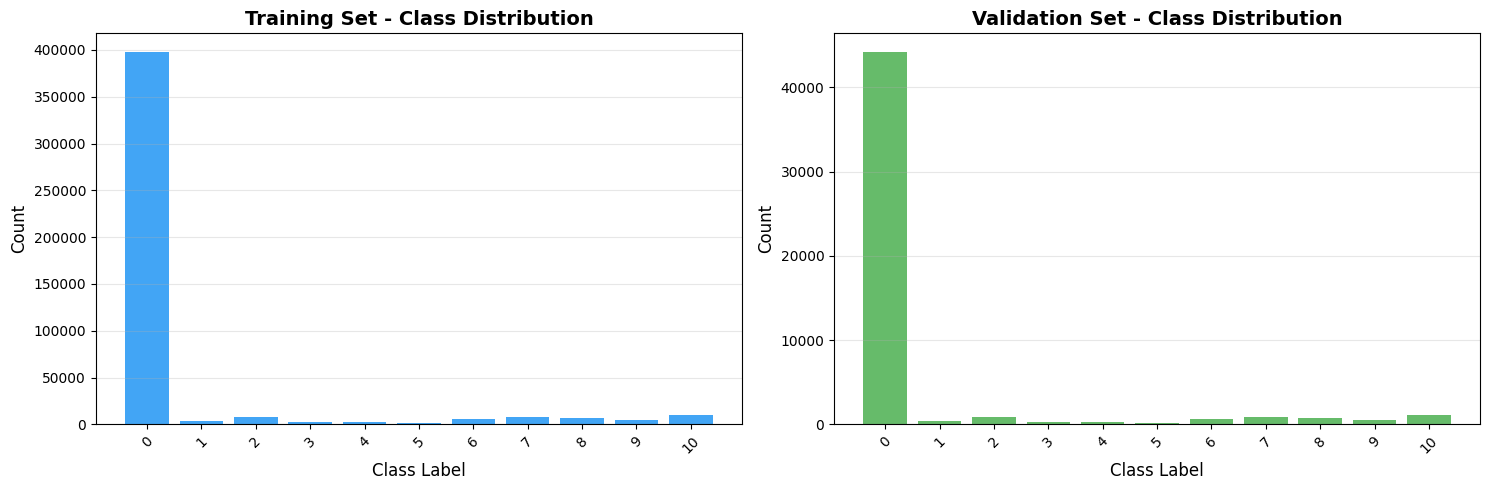

Class balance check:
  Training - Min: 1,771, Max: 397,887, Ratio: 224.67x
  Validation - Min: 197, Max: 44,209, Ratio: 224.41x


In [5]:
# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training distribution
train_counts = train_df['label'].value_counts().sort_index()
ax1.bar(range(len(train_counts)), train_counts.values, color='#42a5f5')
ax1.set_xlabel('Class Label', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Training Set - Class Distribution', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(train_counts)))
ax1.set_xticklabels(train_counts.index, rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Validation distribution
val_counts = val_df['label'].value_counts().sort_index()
ax2.bar(range(len(val_counts)), val_counts.values, color='#66bb6a')
ax2.set_xlabel('Class Label', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Validation Set - Class Distribution', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(val_counts)))
ax2.set_xticklabels(val_counts.index, rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Class balance check:")
print(f"  Training - Min: {train_counts.min():,}, Max: {train_counts.max():,}, Ratio: {train_counts.max()/train_counts.min():.2f}x")
print(f"  Validation - Min: {val_counts.min():,}, Max: {val_counts.max():,}, Ratio: {val_counts.max()/val_counts.min():.2f}x")


## 4. Extract Features

**Note:** This notebook now uses 24 features including:
- **Basic features** (7): code length, line counts, whitespace
- **Keyword features** (10): Python keyword frequencies
- **AST features** (3): function count, nesting depth, loop count
- **Additional features** (4): word count, keyword frequency, comment patterns


In [ ]:
# Extract features
print("Extracting features...")
X_train = extract_features_from_dataframe(train_df)
X_val = extract_features_from_dataframe(val_df)
y_train = train_df['label'].values
y_val = val_df['label'].values

print(f"✅ Feature extraction complete!")
print(f"Feature shape: {X_train.shape}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Number of classes: {len(np.unique(y_train))}")
print(f"\nAll features ({len(X_train.columns)}):")
print(list(X_train.columns))

# Categorize features
basic_features = [f for f in X_train.columns if f in ['code_length', 'num_lines', 'avg_line_length', 'num_spaces', 'num_tabs', 'num_newlines', 'space_ratio']]
keyword_features = [f for f in X_train.columns if f.startswith('kw_')]
ast_features = [f for f in X_train.columns if f in ['num_functions', 'max_nesting', 'num_loops']]
other_features = [f for f in X_train.columns if f not in basic_features + keyword_features + ast_features]

print(f"\n📊 Feature breakdown:")
print(f"  Basic features: {len(basic_features)}")
print(f"  Keyword features: {len(keyword_features)}")
print(f"  AST features: {len(ast_features)}")
print(f"  Additional features: {len(other_features)}")
print(f"  Total: {len(X_train.columns)} features")


Extracting features...
  Processed 450,000/450,000 samples (100.0%)
  Processed 50,000/50,000 samples (100.0%)
✅ Feature extraction complete!
Feature shape: (450000, 24)
Number of features: 24
Number of classes: 11

All features (24):
['code_length', 'num_lines', 'avg_line_length', 'num_spaces', 'num_tabs', 'num_newlines', 'space_ratio', 'kw_def', 'kw_class', 'kw_if', 'kw_for', 'kw_while', 'kw_import', 'kw_from', 'kw_return', 'kw_try', 'kw_except', 'num_functions', 'max_nesting', 'num_loops', 'word_count', 'total_keyword_freq', 'num_comments', 'avg_comment_length']

📊 Feature breakdown:
  Basic features: 7
  Keyword features: 10
  AST features: 3
  Additional features: 4
  Total: 24 features


## 5. Train Models


In [ ]:
# Define advanced gradient boosting models for multi-class problem
models = {}

# Calculate class weights for handling imbalance (per-sample weights for XGBoost)
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight('balanced', y_train)

models['XGBoost'] = {
        'model': XGBClassifier(
            n_estimators=400,
            max_depth=10,
            learning_rate=0.05,
            random_state=42,
            objective='multi:softprob',
            eval_metric='mlogloss',
            n_jobs=-1,
            tree_method='hist',
            min_child_weight=1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=1.0
        ),
        'sample_weight': sample_weights  # pass sample weights to handle imbalance
    }

models['LightGBM'] = {
    'model': LGBMClassifier(
        n_estimators=400,
        max_depth=10,
        learning_rate=0.05,
        random_state=42,
        objective='multiclass',
        num_class=11,
        class_weight='balanced',
        n_jobs=-1,
        verbose=-1,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0
    ),
    'sample_weight': None  # LightGBM uses class_weight parameter
}

# CatBoost
models['CatBoost'] = {
    'model': CatBoostClassifier(
        iterations=400,
        depth=10,
        learning_rate=0.05,
        random_state=42,
        loss_function='MultiClass',
        classes_count=11,
        class_weights='Balanced',
        verbose=False,
        thread_count=-1,
        min_data_in_leaf=20,
        subsample=0.8,
        colsample_bylevel=0.8,
        l2_leaf_reg=3.0
    ),
    'sample_weight': None  # CatBoost uses class_weights parameter
}

results = {}

# Train and evaluate each model
for name, model_config in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print(f"{'='*60}")
    
    model = model_config['model']
    sample_weight = model_config.get('sample_weight', None)
    
    if sample_weight is not None:
        model.fit(X_train, y_train, sample_weight=sample_weight)
    else:
        model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    train_f1 = f1_score(y_train, y_pred_train, average='macro')
    val_f1 = f1_score(y_val, y_pred_val, average='macro')
    
    results[name] = {
        'train_f1': train_f1,
        'val_f1': val_f1,
        'model': model,
        'predictions': y_pred_val
    }
    
    print(f"Train F1: {train_f1:.4f}")
    print(f"Val F1:   {val_f1:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_val, y_pred_val))



Training XGBoost...
Train F1: 0.3715
Val F1:   0.2000

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.70      0.82     44209
           1       0.03      0.14      0.05       416
           2       0.08      0.10      0.09       899
           3       0.05      0.19      0.08       303
           4       0.16      0.52      0.24       223
           5       0.04      0.34      0.07       197
           6       0.23      0.40      0.29       578
           7       0.12      0.19      0.15       820
           8       0.13      0.45      0.20       813
           9       0.04      0.16      0.07       461
          10       0.09      0.44      0.15      1081

    accuracy                           0.65     50000
   macro avg       0.18      0.33      0.20     50000
weighted avg       0.89      0.65      0.74     50000


Training LightGBM...
Train F1: 0.2743
Val F1:   0.1849

Classification Report:
              precision    r

CatBoostError: catboost/private/libs/options/json_helper.h:41: Can't parse parameter "class_weights" with value: "Balanced"

In [ ]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train F1': [r['train_f1'] for r in results.values()],
    'Val F1': [r['val_f1'] for r in results.values()]
})

print(comparison_df)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.35

ax.bar(x - width/2, comparison_df['Train F1'], width, label='Train F1', color='#66bb6a')
ax.bar(x + width/2, comparison_df['Val F1'], width, label='Val F1', color='#42a5f5')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Macro F1 Score', fontsize=12)
ax.set_title('Task B: Model Comparison (11 Classes)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add baseline expectation line
ax.axhline(y=0.40, color='r', linestyle='--', alpha=0.5, label='Expected Baseline (40%)')
ax.axhline(y=0.85, color='g', linestyle='--', alpha=0.5, label='Target (85%)')

plt.tight_layout()
plt.show()


## 7. Confusion Matrix (Best Model)

**Note:** For 11 classes, the confusion matrix will be 11x11. This shows which models are confused with each other.


In [ ]:
# Get best model
best_model_name = max(results, key=lambda k: results[k]['val_f1'])
best_predictions = results[best_model_name]['predictions']

print(f"Best Model: {best_model_name}")
print(f"Validation F1: {results[best_model_name]['val_f1']:.4f}")

# Confusion matrix
cm = confusion_matrix(y_val, best_predictions)

# Create labels for 11 classes
class_labels = [f'Class {i}' for i in range(11)]
# If you know the actual model names, replace above with:
# class_labels = ['Human', 'GPT-3.5', 'GPT-4', 'Claude', 'Codex', ...]

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name} (Task B)', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print per-class accuracy
print("\n📊 Per-Class Accuracy:")
for i in range(11):
    class_mask = y_val == i
    if class_mask.sum() > 0:
        class_acc = (best_predictions[class_mask] == i).mean()
        print(f"  Class {i}: {class_acc:.4f} ({class_mask.sum()} samples)")


## 8. Feature Importance (Best Model)


In [ ]:
# Get feature importance from best model (XGBoost, LightGBM, or CatBoost all support feature importance)
best_model_name = max(results, key=lambda k: results[k]['val_f1'])
best_model = results[best_model_name]['model']

# Check if model supports feature importance
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot top 15 features
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'], color='#66bb6a')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top 15 Most Important Features - {best_model_name} (Task B)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print(f"\nTop 10 Features from {best_model_name}:")
    print(feature_importance.head(10))
else:
    print(f"⚠️  {best_model_name} does not support feature importance visualization")
